In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import getEuclideanDistance
from clustering_utils.clustering import Clustering
from aco_utils.aco import ACO

In [2]:
depot = [4.4184, 114.0932]

customers = np.array([
    [4.3555, 113.9777, 5],
    [4.3976, 114.0049, 8],
    [4.3163, 114.0764, 3],
    [4.3184, 113.9932, 6],
    [4.4024, 113.9896, 5],
    [4.4142, 114.0127, 8],
    [4.4804, 114.0734, 3],
    [4.3818, 114.2034, 6],
    [4.4935, 114.1828, 5],
    [4.4932, 114.1322, 8]
])

vehicles = [
    ["Type A", 25, 1.2],
    ["Type B", 30, 1.5]
]
vehicles = np.array(sorted(vehicles, key=lambda x: x[2]))  # sort the vehicles based on cost

# Cluster the Customers

In [3]:
best_clusters = []  # to record the best clusters
min_demand = int(min(customers[:, 2]))  # min demand amoung the customers
max_capacity = int(max(vehicles[:, 1]))  # max capacity same as the capacity of the biggest vehicle

# calculate the best cluster for max capacity of clusters very from max_capacity to min_demand
for i in range(max_capacity, min_demand, -min_demand): 
    best_clusters.append(Clustering(i, customers))

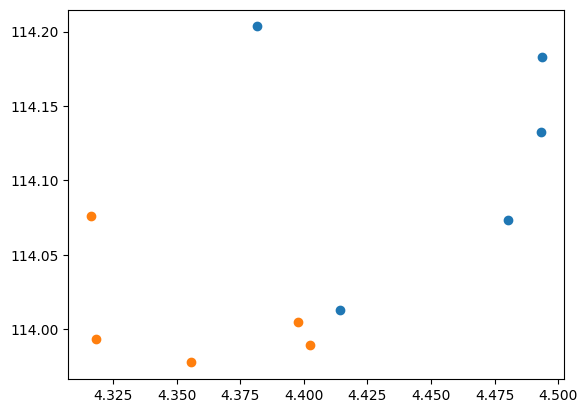

In [4]:
# Display the first best cluster
for cluster in best_clusters[0].clusters:
  plt.scatter(customers[cluster.node_indices, 0], customers[cluster.node_indices, 1])
plt.show()

# Ant Colony Optimization

In [5]:
# Add depot to the customer coordinates
customers = np.concatenate(([[depot[0], depot[1], 0]], customers))

# Calculate the distance matrix of the customers
distance_matrix = np.array([[getEuclideanDistance(point1, point2) for point2 in customers] for point1 in customers])
for i in range(len(distance_matrix)):
  distance_matrix[i][i] = np.inf

In [6]:
min_cost = np.inf
min_distance = -1
best_routes = []
final_cluster = None
final_vehicles = []

for best_cluster in best_clusters: # for each possible best cluster
  cost = 0  # total cost travelled by all the vehicles
  distance = 0
  routes = []
  route_vehicles = []

  for cluster in best_cluster.clusters:  # for each cluster
    # add depot to the cluster
    indices = np.add(cluster.node_indices, 1)  
    indices = np.insert(indices, 0, 0)
    cluster.node_indices = indices

    # get the subset of the distance matrix based on the cluster nodes
    cropped_distance_mat = distance_matrix[indices]
    cropped_distance_mat = cropped_distance_mat[:, indices]

    # perform ACO 
    aco = ACO(len(cropped_distance_mat), cropped_distance_mat)
    aco.fit(500)

    # get the minimum vehicle cost to the cluster
    vehicle_cost = -1
    for vehicle in vehicles:
      if int(vehicle[1]) >= np.sum(customers[indices, 2]):
        vehicle_cost = vehicle[2]
        route_vehicles.append(vehicle)
        break

    # record results
    distance += aco.shortest_distance 
    cost += distance * float(vehicle_cost)
    routes.append([indices[index] for index in aco.best_route])
  
  if cost < min_cost:
    min_cost = cost
    min_distance = distance
    best_routes = routes
    final_cluster = best_cluster
    final_vehicles = route_vehicles

In [7]:
print(f"Total Distance =", "{:.2f}".format(min_distance), "km")
print(f"Total Cost = RM", "{:.2f}".format(min_cost), "\n")

for i in range(len(best_routes)):
    print(f"Vehicle: {final_vehicles[i][0]}")
    print("Route:")
    print([x.item() for x in best_routes[i]])
    print()

Total Distance = 3216.51 km
Total Cost = RM 7248.30 

Vehicle: Type B
Route:
[0, 7, 6, 10, 8, 9, 0]

Vehicle: Type B
Route:
[0, 3, 1, 4, 2, 5, 0]



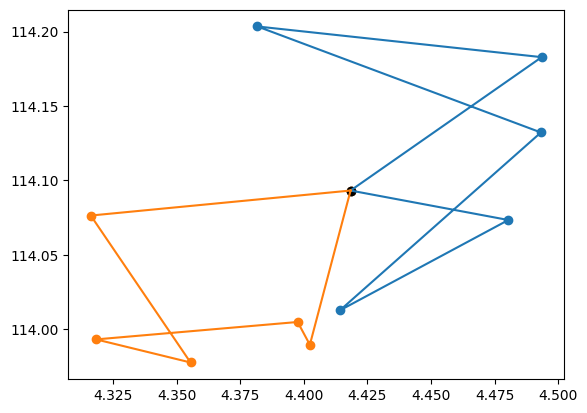

In [8]:
# Display the best routes
for cluster in final_cluster.clusters:
  plt.scatter(customers[cluster.node_indices, 0], customers[cluster.node_indices, 1])

for route in best_routes:
  xs = customers[route, 0]
  ys = customers[route, 1]
  plt.plot(xs, ys)

plt.scatter([depot[0]], [depot[1]], c="black")
plt.show()